In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import pandas as pd

2024-07-23 14:34:39.860341: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 14:34:48.807347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
classes_train_og = pd.read_csv('../data/train/_classes.csv', delimiter=',', index_col=0).to_numpy()
classes_test_og = pd.read_csv('../data/test/_classes.csv', delimiter=',', index_col=0).to_numpy()
classes_valid_og = pd.read_csv('../data/valid/_classes.csv', delimiter=',', index_col=0).to_numpy()

classes_aug = pd.read_csv('../data/labels_aug_v2.csv', delimiter=',', index_col=0).to_numpy()

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 1 0 0 0 0]]


In [4]:
with open('../data/valid.json',"r") as f:
    data = json.load(f)
    valid_og = np.array(data)

with open('../data/test.json',"r") as f:
    data = json.load(f)
    test_og = np.array(data)

with open('../data/train.json',"r") as f:
    data = json.load(f)
    train_og = np.array(data)

with open('../data/labels_aug_v2.json',"r") as f:
    data = json.load(f)
    aug = np.array(data)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier

In [6]:
X_train_og = train_og/255.0
y_train_og = classes_train_og
#only use first 10% of the data
X_train_og = X_train_og[:int(len(X_train_og)/10)]
y_train_og = y_train_og[:int(len(y_train_og)/10)]

X_valid_og = valid_og/255.0
y_valid_og = classes_valid_og
#only use first 10% of the data
X_valid_og = X_valid_og[:int(len(X_valid_og)/10)]
y_valid_og = y_valid_og[:int(len(y_valid_og)/10)]

X_test = test_og/255.0
y_test = classes_test_og

X_aug = aug/255.0
y_aug = classes_aug

from sklearn.model_selection import train_test_split
X_aug_train_val, X_aug_test, y_aug_train_val, y_aug_test = train_test_split(X_aug, y_aug, test_size=0.07, random_state=42)

# Second split: 75% of train+val (60% of total) for training, 25% of train+val (20% of total) for validation
X_aug_train, X_aug_val, y_aug_train, y_aug_val = train_test_split(X_aug_train_val, y_aug_train_val, test_size=0.14, random_state=42)

In [7]:
from keras.optimizers import Adam
class model_init:
    def __init__(self, classes, input_shape, num_dense_layers, num_dense_units, num_conv_layers, filters, kernel_size, pool_size, dropout_rate):
        """
        Initialize the model with the given parameters
        """
        self.classes = classes
        self.input_shape = input_shape
        self.num_dense_layers = num_dense_layers
        self.num_dense_units = num_dense_units
        self.num_conv_layers = num_conv_layers
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.dropout_rate = dropout_rate

        self.model = self.build_model()

    def conv_block(self, input, filters, kernel_size, pool_size):
        """
        Convolutional block with Conv2D, Activation and MaxPooling2D layers
        """
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding="valid", activation="elu")(input)
        x = tf.keras.layers.Conv2D(filters, kernel_size, padding="valid", activation="elu")(x)
        x = tf.keras.layers.Conv2D(2*filters, kernel_size, padding="valid", activation="elu")(x)
        x = tf.keras.layers.MaxPooling2D(pool_size)(x)
        return x
    
    def dense_block(self, input, units, dropout):
        """
        Dense block with Dense, Activation and Dropout layers
        """
        x = tf.keras.layers.Dense(units, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(input)
        x = tf.keras.layers.Dropout(dropout)(x)
        return x
    
    def build_model(self):
        """
        Build the model with the given parameters
        """
        input = tf.keras.layers.Input(shape=self.input_shape)

        x = self.conv_block(input, self.filters, self.kernel_size, self.pool_size)
        for i in range(self.num_conv_layers - 1):
            x = self.conv_block(x, self.filters, self.kernel_size, self.pool_size)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("elu")(x)
        x = tf.keras.layers.Dropout(self.dropout_rate)(x)

        x = self.conv_block(input, self.filters, self.kernel_size, self.pool_size)
        for i in range(self.num_conv_layers - 1):
            x = self.conv_block(x, self.filters, self.kernel_size, self.pool_size)

        x = tf.keras.layers.Flatten()(x)
        
        for i in range(self.num_dense_layers):
            x = self.dense_block(x, self.num_dense_units, self.dropout_rate)
        output = tf.keras.layers.Dense(self.classes, activation="softmax")(x)
        model = tf.keras.Model(inputs=input, outputs=output)
        return model
    


model = model_init(6, input_shape=(X_train_og[0].shape[0], X_train_og[0].shape[1], 1), num_dense_layers=2, num_dense_units=256, num_conv_layers=2, filters=64, kernel_size=(3, 3), pool_size=(3, 3), dropout_rate=0.6)

model = model.build_model()

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_og, y_train_og, batch_size=64, epochs=100, validation_data=(X_valid_og, y_valid_og), callbacks=[early_stopping])

Epoch 1/100


2024-07-16 14:17:30.747341: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 146841600 exceeds 10% of free system memory.
2024-07-16 14:17:33.780970: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 491847680 exceeds 10% of free system memory.
2024-07-16 14:17:34.553148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 480509952 exceeds 10% of free system memory.
2024-07-16 14:17:36.032044: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 938606592 exceeds 10% of free system memory.
2024-07-16 14:17:38.278748: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103612416 exceeds 10% of free system memory.


19/19 ━━━━━━━━━━━━━━━━━━━━ 255s 13s/step - accuracy: 0.2957 - loss: 9.1942 - val_accuracy: 0.4583 - val_loss: 7.0026
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 277s 15s/step - accuracy: 0.3941 - loss: 6.6776 - val_accuracy: 0.5104 - val_loss: 5.2758
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 269s 14s/step - accuracy: 0.4740 - loss: 5.0721 - val_accuracy: 0.5521 - val_loss: 4.2652
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 240s 13s/step - accuracy: 0.5287 - loss: 4.1729 - val_accuracy: 0.4583 - val_loss: 3.7955
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 235s 12s/step - accuracy: 0.5417 - loss: 3.6536 - val_accuracy: 0.5781 - val_loss: 3.3088
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 241s 13s/step - accuracy: 0.5618 - loss: 3.3040 - val_accuracy: 0.6719 - val_loss: 2.9819
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 242s 13s/step - accuracy: 0.6841 - loss: 2.9091 - val_accuracy: 0.7135 - val_loss: 2.7428
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 238s 13s/step - accuracy: 0.6811 - loss: 2.7427 - val_accuracy: 0.7396

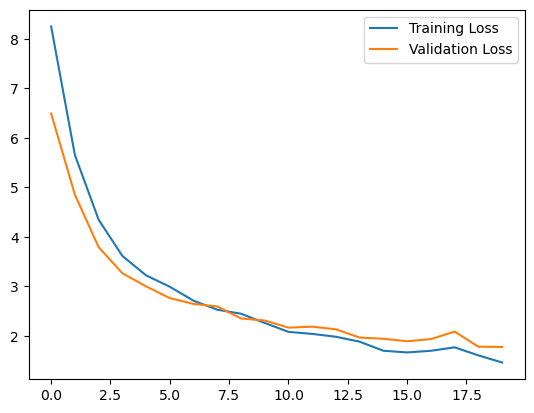

In [ ]:
#plot the training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()